# Random Forest Regressor using TA features to Predict BTC future price moves
This notebook is a work in progress. 

In [1]:
import vectorbt as vbt
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import logging
import pickle
from tqdm import tqdm




If you do not have a datafile you can use the notebook `get-data.ipynb` to download some bitcoin data. You can store it in the `/data` folder as `btc.csv`

In [4]:

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

logging.info(f"Loading data")
data = pd.read_csv('../data/btc.csv', index_col=0, parse_dates=True) # I'm using minutely data

# just keep the 'Close' and 'Volume' columns
data = data[['Close', 'Volume']]


2023-03-21 07:40:51,740 - INFO - Loading data


In [5]:
# Create an indicator of the EMA of the close price
ema1_period = 20000
ema2_period = 5000
sma1_period = 10000
sma2_period = 1000
data.ta.ema(close='Close', length=ema1_period, append=True)
data.ta.ema(close='Close', length=ema2_period, append=True)
data.ta.sma(close='Close', length=sma1_period, append=True)
data.ta.sma(close='Close', length=sma2_period, append=True)
data.dropna(inplace=True)

forecast = 30
data['ema1_signal'] = (data['Close']/data[f'EMA_{ema1_period}'])-1
data['ema2_signal'] = (data['Close']/data[f'EMA_{ema2_period}'])-1
data['sma1_signal'] = (data['Close']/data[f'SMA_{sma1_period}'])-1
data['sma2_signal'] = (data['Close']/data[f'SMA_{sma2_period}'])-1

data[f'forecast_{forecast}'] = data['Close'].shift(-forecast).pct_change(forecast).dropna()
data['future'] = data['Close'].shift(-forecast)
data.dropna(inplace=True)

df = data.copy()
logging.info(f"Forecasting {forecast} mins fwd.")
logging.info(f'Using {ema1_period} and {ema2_period} ema periods')
logging.info(f'Using {sma1_period} and {sma2_period} sma periods')


2023-03-21 07:52:53,300 - INFO - Forecasting 30 mins fwd.
2023-03-21 07:52:53,301 - INFO - Using 20000 and 5000 ema periods
2023-03-21 07:52:53,301 - INFO - Using 10000 and 1000 sma periods


In [7]:
# Create the features (X) and target (y) data using numpy
X = df[['ema1_signal', 'ema2_signal', 'sma1_signal', 'sma2_signal', 'Volume']].iloc[:-forecast].values # signal and volume
y = df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values.reshape(-1, 1) # future

# Split the data into training and testing sets and make sure they are the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Create the model and fit it to the data
logging.info(f"Creating model")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y.ravel())
logging.info(f"Model fitted")
y_val = df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = df[['ema1_signal', 'ema2_signal', 'sma1_signal', 'sma2_signal', 'Volume']][-len(y_val):] # signal and volume
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
y_pred = model.predict(X_val.values)
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]


2023-03-21 07:58:40,592 - INFO - Model fitted
2023-03-21 07:58:40,636 - INFO - Making predictions
2023-03-21 07:58:43,097 - INFO - Predictions made


In [8]:
def calculate_and_print_results(y_val, y_pred, threshold=0.0005):

    mse = mean_squared_error(y_pred, y_val)
    rmse = np.sqrt(mse)
    correct_predictions = np.abs(y_pred - y_val.ravel()) <= threshold
    direction_correct = (np.sign(y_pred) == np.sign(y_val.ravel())).astype(int)
    direction_accuracy = direction_correct.mean() * 100
    accuracy = np.mean(correct_predictions) * 100
    r2 = r2_score(y_val, y_pred)

    print(f"For a threshold of: {threshold}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse:.4f}")
    # print accuracy within 4 decimal places
    print(f"Accuracy: {accuracy:.4f}%")
    print(f"Direction Accuracy: {direction_accuracy:.4f}% This happened {direction_correct.sum()} times out of {len(direction_correct)}")
    print(f"R-squared: {r2:.4f}")
    results = {
        'mse': mse,
        'rmse': rmse,
        'accuracy': accuracy,
        'direction_accuracy': direction_accuracy,
        'r2': r2
    }
    return results

stats = calculate_and_print_results(y_val, y_pred, threshold=0.001)


For a threshold of: 0.001
MSE: 1.1840150881180445e-06
RMSE: 0.0011
Accuracy: 83.0634%
Direction Accuracy: 94.2566% This happened 530426 times out of 562747
R-squared: 0.9468


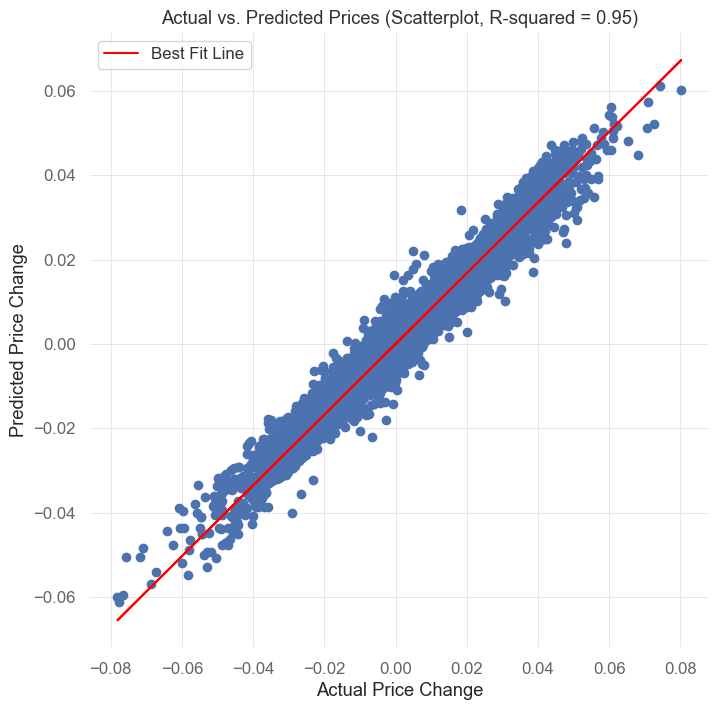

In [9]:
# Create a scatter plot of the predictions versus the actual values
def plot_scatter(y_val, y_pred, r2):

    # Fit a line of best fit to the data
    coeffs = np.polyfit(y_val.ravel(), y_pred.ravel(), 1)
    line = coeffs[0] * y_val.ravel() + coeffs[1]

    # Plot actual vs predicted prices as scatterplot
    plt.figure(figsize=(8, 8))
    plt.scatter(y_val, y_pred)
    plt.xlabel('Actual Price Change')
    plt.ylabel('Predicted Price Change')
    plt.title(f'Actual vs. Predicted Prices (Scatterplot, R-squared = {r2:.2f})')

    # Add best fit line
    plt.plot(y_val.ravel(), line, color='red', label='Best Fit Line')
    plt.legend()

    plt.show()

plot_scatter(y_val, y_pred, stats['r2'])

In [12]:
# Save the model
file_name = f'../models/rf_model_ema{ema1_period}-ema{ema2_period}-sma{sma1_period}-sma{sma2_period}-f{forecast}.pkl'
with open(file_name,  'wb') as file:
    pickle.dump(model, file)

# Create a bunch of features using Pandas_TA
Pandas_ta has a nice capability to create your own indicators as a `Strategy` class. The following are features that I played around with. 

In [13]:
momo_bands_sma_ta = [
    {"kind":"sma", "length": 1000},
    {"kind":"sma", "length": 20000},
    {"kind":"ema", "length": 10000},
    {"kind":"ema", "length": 5000},
    {"kind":"bbands", "length": 2000, "ddof": 0},
    {"kind":"macd"},
    {"kind":"rsi"},
    {"kind":"log_return", "cumulative": True},
    {"kind":"sma", "close": "CUMLOGRET_1", "length": 50, "suffix": "CUMLOGRET"},
]
momo_bands_sma_strategy = ta.Strategy(
    "Momo, Bands, MAs and Cumulative Log Returns", # name
    momo_bands_sma_ta, # ta
    "MACD, RSI, Momo with BBANDS and EMAs, SMAs and Cumulative Log Returns" # description
)
momo_bands_sma_strategy

Strategy(name='Momo, Bands, MAs and Cumulative Log Returns', ta=[{'kind': 'sma', 'length': 1000}, {'kind': 'sma', 'length': 20000}, {'kind': 'ema', 'length': 10000}, {'kind': 'ema', 'length': 5000}, {'kind': 'bbands', 'length': 2000, 'ddof': 0}, {'kind': 'macd'}, {'kind': 'rsi'}, {'kind': 'log_return', 'cumulative': True}, {'kind': 'sma', 'close': 'CUMLOGRET_1', 'length': 50, 'suffix': 'CUMLOGRET'}], description='MACD, RSI, Momo with BBANDS and EMAs, SMAs and Cumulative Log Returns', created='Tuesday March 21, 2023, NYSE: 3:39:13, Local: 7:39:13 PDT, Day 80/365 (22.00%)')

Add the new features to the dataframe

In [16]:

data.ta.strategy(momo_bands_sma_strategy, append=True) # Add the new features to the dataframe
data.dropna(inplace=True)
# Print the columns
data.tail()

,Close,Volume,EMA_20000,EMA_5000,SMA_10000,SMA_1000,ema1_signal,ema2_signal,sma1_signal,sma2_signal,...,BBM_2000_2.0,BBU_2000_2.0,BBB_2000_2.0,BBP_2000_2.0,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,CUMLOGRET_1,SMA_50_CUMLOGRET
Open time,,,,,,,,,,,,,,,,,,,,,
2023-02-10 01:21:00+00:00,21848.03,131.29390,22868.844618,22785.656800,23063.973307,22374.02512,-0.044638,-0.041150,-0.052720,-0.023509,...,22593.317185,23317.647947,6.411903,-0.014466,5.279111,-0.705265,5.984377,52.971360,-0.661334,-0.661805
2023-02-10 01:22:00+00:00,21841.65,135.05846,22868.741904,22785.279273,23063.813767,22373.16212,-0.044912,-0.041414,-0.052991,-0.023757,...,22592.801280,23317.802683,6.417986,-0.018034,4.276182,-1.366556,5.642738,48.660380,-0.661626,-0.661777
2023-02-10 01:23:00+00:00,21842.26,95.54590,22868.639261,22784.902141,23063.655320,22372.29928,-0.044882,-0.041371,-0.052958,-0.023692,...,22592.280400,23317.940759,6.423967,-0.016785,3.490341,-1.721918,5.212258,49.087016,-0.661598,-0.661754
2023-02-10 01:24:00+00:00,21849.56,138.73977,22868.537358,22784.528079,23063.498004,22371.44612,-0.044558,-0.041035,-0.052635,-0.023328,...,22591.766175,23318.073193,6.429838,-0.010945,3.417213,-1.436036,4.853249,54.012225,-0.661264,-0.661738
2023-02-10 01:25:00+00:00,21832.77,238.23456,22868.433786,22784.147451,23063.336782,22370.57699,-0.045288,-0.041756,-0.053356,-0.024041,...,22591.246730,23318.237977,6.436044,-0.021655,1.981604,-2.297316,4.278920,43.571878,-0.662033,-0.661740


# Now build a model using the new columns as features

In [19]:
forecast = 90 # minutes into the future to predict
df = data.copy()
cols = df.columns

# Create the features (X) and target (y) data using numpy
X = df[cols].iloc[:-forecast].values # signal and volume
y = df['Close'].pct_change(forecast).dropna().iloc[:-forecast].values.reshape(-1, 1) # future

# Split the data into training and testing sets and make sure they are the same length
min_length = min(len(X), len(y))
X = X[:min_length]
y = y[:min_length]

# Create the model and fit it to the data
logging.info(f"Fitting model")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X, y.ravel())
logging.info(f"Model fitted")
y_val = df['Close'].shift(-forecast).pct_change(forecast).dropna() # future
X_val = df[cols][-len(y_val):] # signal and volume
y_val = y_val.values.reshape(-1, 1) # reshape to 2D
# make predictions
logging.info(f"Making predictions")
y_pred = model.predict(X_val.values)
logging.info(f"Predictions made")

# remove NaNs and infinities
valid_indices = ~np.isnan(y_pred) & ~np.isnan(y_val.ravel()) # remove NaNs
y_pred = y_pred[valid_indices]
y_val = y_val[valid_indices]

2023-03-21 08:30:03,865 - INFO - Fitting model
2023-03-21 08:37:14,192 - INFO - Model fitted
2023-03-21 08:37:14,350 - INFO - Making predictions
2023-03-21 08:37:17,348 - INFO - Predictions made


In [20]:
def calculate_and_print_results(y_val, y_pred, threshold=0.0005):

    mse = mean_squared_error(y_pred, y_val)
    rmse = np.sqrt(mse)
    correct_predictions = np.abs(y_pred - y_val.ravel()) <= threshold
    direction_correct = (np.sign(y_pred) == np.sign(y_val.ravel())).astype(int)
    direction_accuracy = direction_correct.mean() * 100
    accuracy = np.mean(correct_predictions) * 100
    r2 = r2_score(y_val, y_pred)

    print(f"For a threshold of: {threshold}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse:.4f}")
    # print accuracy within 4 decimal places
    print(f"Accuracy: {accuracy:.4f}%")
    print(f"Direction Accuracy: {direction_accuracy:.4f}% This happened {direction_correct.sum()} times out of {len(direction_correct)}")
    print(f"R-squared: {r2:.4f}")
    results = {
        'mse': mse,
        'rmse': rmse,
        'accuracy': accuracy,
        'direction_accuracy': direction_accuracy,
        'r2': r2
    }
    return results

stats = calculate_and_print_results(y_val, y_pred, threshold=0.001)


For a threshold of: 0.001
MSE: 1.2729619990324905e-06
RMSE: 0.0011
Accuracy: 83.8493%
Direction Accuracy: 96.6824% This happened 486013 times out of 502690
R-squared: 0.9802


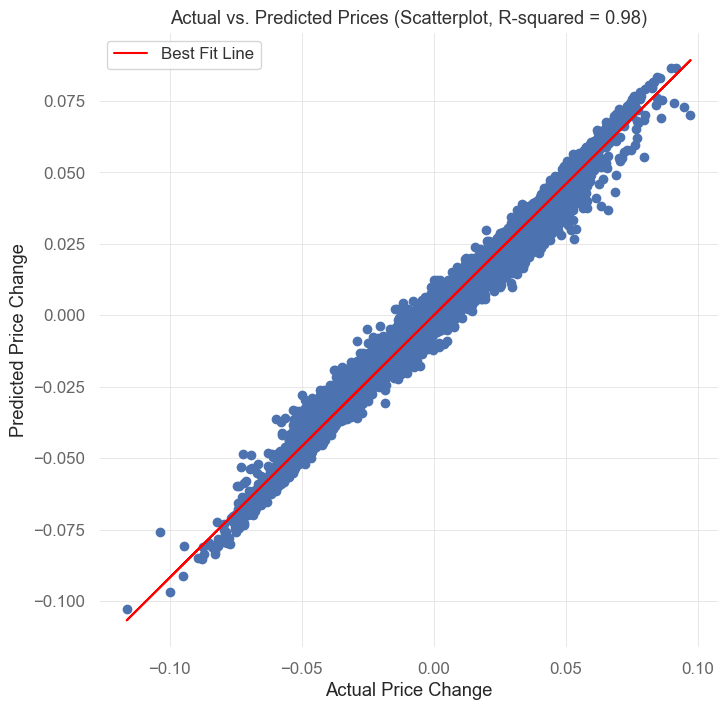

In [21]:
plot_scatter(y_val, y_pred, stats['r2'])